### BERT모델로 네이버 영화 리뷰 감성 분류해보기

BERT모델을 공부하는 김에 간단한 실습을 해보고자한다.

여러 블로그들을 참고하며 코드를 작성해보았고,

특히 https://teddylee777.github.io/huggingface/bert-kor-text-classification/ 여기 블로그를 많이 참고하였다.

우선 이번에는 코드를 뜯어보고 체화시키기위함이라, 다음엔 더 내 코드로 만드는 것을 목표로 삼아야겠다!


In [1]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Counting objects: 100% (14762/14762), done.
remote: Compressing objects: 100% (13012/13012), done.
remote: Total 14763 (delta 1748), reused 14762 (delta 1748), pack-reused 1
Receiving objects: 100% (14763/14763), 56.19 MiB | 4.07 MiB/s, done.
Resolving deltas: 100% (1748/1748), done.
Updating files: 100% (14737/14737), done.


In [2]:
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime
import os

# devices = torch.cuda.device_count()
# print('device nums: ', devices)

# for i in range(devices):
#   print(i, ':', torch.cuda.get_device_name(i))

train = pd.read_csv('./nsmc/ratings_train.txt', sep='\t')
test = pd.read_csv('./nsmc/ratings_test.txt', sep='\t')

print('train shape : ',train.shape)
print('test shape : ', test.shape)

train shape :  (150000, 3)
test shape :  (50000, 3)


In [3]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(f'사용 device: {device}')

0    75173
1    74827
Name: label, dtype: int64


<Axes: >

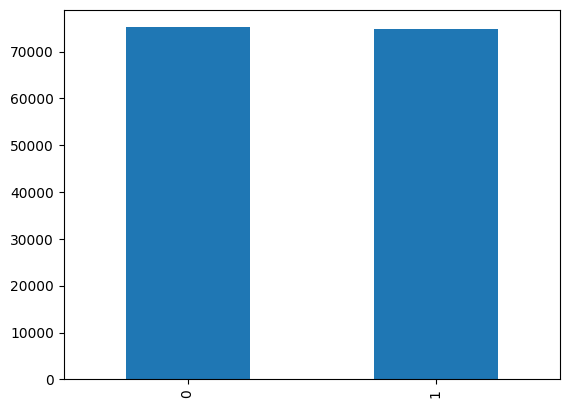

In [4]:
# train 데이터 분포도 보기
import matplotlib.pyplot as plt
print(train['label'].value_counts())
train['label'].value_counts().plot(kind='bar')

In [5]:
# 긍정 : 1, 부정 : 0 으로 분류된 것을 확인할 수 있음
# -> 더 자세한 감정들로 mapping??
display(train)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [6]:
# train, test 데이터 결측치 알아보기
print(train.isna().sum())
print(test.isna().sum())

id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64


In [7]:
train = train.dropna()
test = test.dropna()
print(train.isna().sum())
print(test.isna().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


In [8]:
# 중복행 있는지 검사 -> 없길래 넘어감
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [9]:
# 결측치 제거 후 인덱스 재정렬
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [10]:
train['length'] = train['document'].apply(lambda x: len(str(x)))
test['length'] = test['document'].apply(lambda x: len(str(x)))

train = train.loc[train['length']>5]
train = train.sample(1000)

test = test.loc[test['length']>5]
test = test.sample(500)

In [11]:
train = train.drop(['id', 'length'], axis=1)
train = train.reset_index(drop=True)
train

,document,label
0,그의 세상을 바라보는 따뜻한 시선과 사람에 대한 애정이 온전히 담겨져 있다,1
1,유치하죠..,0
2,아니 ㅅㅂ 옛날엔 재밌었을지 모르지만 지금은 2013년이라고 ㅡㅡ 2013 관객의 ...,0
3,이렇게 재미없어도 되나 싶을 정도로 드릅게 재미없네유.,0
4,초속5센티미터 만큼의 지루함과 파워레인저 급의 유치함. 편의점불타고 주인공 원숭이탈...,0
...,...,...
995,영화 진짜 재미 있게 잘 봤고 알랭드롱 사람이 아니네,1
996,관람하지 못 해서 내용을 알 수 없다신고,0
997,세상에 대한 신랄한 풍자에 박수를 보냅니다,1
998,좀 지루했지만~나름재밌었는뎀 ㅋㅋㅋ,1


In [12]:
test = test.drop(['id', 'length'], axis=1)
test = test.reset_index(drop=True)
test

,document,label
0,두번봤는데 개봉할때 어제. 마지막에 독일군이 그냥 간건 독일내에서 전투를 벌이고 있...,1
1,평점 너무 높고 보면서 상당히 불쾌했다 삐뚤어진 모성애를 합리화시키는 영화,0
2,이거 진짜 재밌음ㅋㅋ!10자,1
3,여자애 때문에 별점 1점,0
4,very good !,1
...,...,...
495,대한민국 영화 정말 실망스럽네요. 딱 3점짜리 영화입니다. 정말 재미없습니다.,0
496,얼굴에 점이라도 찍어주시던가~ 고개를 계속 왼쪽으로 해주시던가~ 헷갈리~,0
497,애초부터 어처구니없는시도 ㅋㅋ역시나 다를까 시청률 5프로 ㅋㅋ 뱁새가 황새 쫒아가다...,0
498,학교 다닐 때 그런 애들 있지? 굉장히 착한데 공부는 드럽게 못 하는.. 이 영화가...,0


In [13]:
# !pip install konlpy

In [14]:
# # 데이터 단어 분포수 보기 위해 wordcloud로 시각화해보기
# from wordcloud import WordCloud, STOPWORDS
# from matplotlib import rc
# from collections import Counter
# import urllib.request

# stopwords = set(STOPWORDS)

# # 한글 폰트
# urllib.request.urlretrieve("http://macsplex.com/?module=file&act=procFileDownload&file_srl=2851&sid=ea4a36b12467c4446c21e70762c7d10f&module_srl=2822g", filename="AppleGothic.ttf")

# words = " ".join(train['document'].tolist())
# c = Counter(words)

# wc = WordCloud(font_path='AppleGothic.ttf',
#                       width=400, height=400,
#                       max_font_size=250, stopwords=stopwords)
# gen = wc.generate_from_frequencies(c)
# plt.figure()
# plt.imshow(wc)

In [15]:
model_name = 'kykim/bert-kor-base'

### transformer Tokenizer들

- BertTokenizer

: BERT모델을 위해 개발된 표준 토크나이저
- BertTokinizerFast

: BertTokenizer과 동일한 토큰화 방식을 제공하지만 더 빠른 성능과 추가적인 기능을 제공.

대규모 데이터셋 처리할 때 시간 효율성 중요한 경우에 유용
- PreTrainedTokenizer

: 다양한 사전훈련 모델에 공통적으로 사용되는 범용 토크나이저 베이스 클래스.

모델에 따라 구체적인 토큰화 방식이 다를 수 있는 다양한 Pre-Trainded 모델에 대한 일관된 인터페이스 제공

------

### Python의 Magic Methods

###  _ _ init _ _ 함수

: python에서 클래스의 생성자(Constructor)로 사용된다.

'매직 메서드' 또는 '던더(Dunder, Double UNDERscore)메서드' 중 하나이다.

즉, 클래스의 새 인스턴스가 생성될 때 자동으로 호출되며, 객체 초기화를 위해 사용된다.

또한 객체 생성시 필요한 인자들을 전달받아 객체의 초기상태를 구성할 때 사용된다.

### _ _ getitem _ _ 함수

: 컬렉션이나 시퀀스 형태의 데이터를 다루는 클래스에서 사용된다.

예를들어, 리스트, 튜플, 데이터프레임과 같은 컬렉션에 저장된 항목을 인덱싱하여 반환하고자할때 사용된다.



> init함수와 다른점

클래스의 인스턴스가 인덱싱(Indexing) 될 때 호출된다.

즉, 클래스의 인스턴스에 대해 [] 연산자를 사용할 때 이 메서드가 자동으로 호출



-----

### 스페셜 토큰(Special Token)?

: 토큰화 과정에서 특별한 목적을 가진 토큰.

BERT와 같은 사전 훈련된 모델에서는 다음과 같은 스페셜 토큰이 자주 사용된다.

- [CLS]: 문장의 시작을 나타내는 토큰. 분류 작업에 사용.
- [SEP]: 문장의 끝을 나타내거나, 두 문장을 구분하는 데 사용.
- [PAD]: 길이를 맞추기 위해 사용되는 패딩 토큰.

In [16]:
import torch
from transformers import BertTokenizerFast
from torch.utils.data import Dataset, DataLoader

class Tokenizing(Dataset):
  # init 함수 생성
  def __init__(self, data, model_name):
    self.data = data # document, label로 구성된 dataframe 전달
    self.tokenizer = BertTokenizerFast.from_pretrained(model_name) # Huggingface 토크나이저 생성

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sentence = self.data.iloc[idx]['document'] #iloc : dataframe 정수기반 위치 인덱싱
    label = self.data.iloc[idx]['label']

    # 토크나이징
    tokens = self.tokenizer(
        sentence,               # 1개 문장
        return_tensors='pt',    # 텐서로 반환
        truncation=True,        # 잘라내기 적용
        padding='max_length',   # padding 적용
        add_special_tokens=True # 스페셜 토큰 적용
    )

    input_ids = tokens['input_ids'].squeeze(0)          #2D->1D
    attention_mask = tokens['attention_mask'].squeeze(0)#2D->1D
    token_type_ids = torch.zeros_like(attention_mask) # 단일문장 처리
    # BERT는 두개 문장 입력시 0과1로 구분함. 위 코드로 어텐션마스크 크기만큼의 0텐서를 생성하여 단일문장만 처리하도록함.

    return {
        'input_ids' : input_ids,
        'attention_mask' : attention_mask,
        'token_type_ids' : token_type_ids,
    }, torch.tensor(label)

### DataLoader의 필요성

data loader 필요함. 왜냐? neural network는 batch 단위로 학습하기 때문

batch단위로 학습한다는 것 = data를 항상 2차원으로 받는다 == batch_size * data shape 형태를 만들어줘야한다.

이걸 자동적으로 하기 위해 data loader로 dataset을 lapping 해주는것임

In [17]:
train_data = Tokenizing(train, model_name)
test_data = Tokenizing(test, model_name)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=8)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/344k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
#inputs는 입력으로 들어가는 x데이터
#inputs.keys = dict_keys(['input_ids', 'attention_mask', 'token_type_ids'])

# k,v in inputs.items()에서
# k : inputs.items 이름
# v : items의 tensors

inputs, label = next(iter(train_loader))
for k, v in inputs.items():
  print('printing k---\n',k)
  print('printing v---\n',v)

print('------')
print(inputs.keys())
print(inputs)
print('---')
print(label)

printing k---
 input_ids
printing v---
 tensor([[    2, 39436,  8018,  ...,     0,     0,     0],
        [    2, 39436,  8018,  ...,     0,     0,     0],
        [    2, 15102,  8144,  ...,     0,     0,     0],
        ...,
        [    2, 14147,  8165,  ...,     0,     0,     0],
        [    2, 14000, 16419,  ...,     0,     0,     0],
        [    2, 26333, 14158,  ...,     0,     0,     0]])
printing k---
 attention_mask
printing v---
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
printing k---
 token_type_ids
printing v---
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------
dict_keys(['input_ids', 'attention_mask', 'token_type_ids'])
{'in

### model 설정하기

1개의 tensor를 빼서 input으로 모델에 넣은 결과를 output 에 담은 후 key를 출력해 보면 'last_hidden_state' 와 'pooler_output'이렇게 2개가 출력된다.

** input 형태

- last_hidden_state : 배치의 각 시퀀스에서 각 토큰에 대한 숨겨진 표현을 포함. (batch_size, seq_len, hidden_size)

- pooler_output : 배치의 각 시퀀스의 '표현'을 포함하며 (batch_size, hidden_size). 각 시퀀스의 [CLS] 토큰의 숨겨진 표현을 가져온 다음 BertPooler를 통해 실행하는 것으로 선형 레이어와 Tanh 활성화 함수로 구성됨.


### 용어 정리

드롭아웃(dropout)

: 신경망의 과적합 방지 기법 중 하나로, 훈련 과정에서 무작위로 일부 뉴런을 비활성화시키는 방법이다.(테스트나 평가시에는 적용X)

dropout_rate=0.5라면 각 훈련단계에서 무작위로 50%의 뉴런을 비활성화시킨다.

드롭아웃의 주요 목적 :

1. 과적합 방지: 모델이 훈련 데이터에 지나치게 의존하는 것을 방지하여 일반화 능력을 향상시킴.
2. 모델의 강인성 향상: 뉴런의 비활성화로 인해 모델이 더욱 견고해지고, 다양한 특징을 학습할 수 있게 함.

In [19]:
from transformers import BertConfig

config = BertConfig.from_pretrained(model_name)
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "embedding_size": 768,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 42000
}

In [20]:
from transformers import BertModel
import torch
import torch.nn as nn
import torch.optim as optim

class CustomBert(nn.Module):
  def __init__(self, model_name, dropout_rate=0.5):
    # 부모 클래스 초기화
    super(CustomBert, self).__init__()
    # Pre-Trained 모델 지정
    self.bert = BertModel.from_pretrained(model_name)
    # dropout 설정하기
    self.dr = nn.Dropout(p=dropout_rate)
    # 최종 출력층 정의 (768,2)
    # 768은 BERT모델의 'hidden_size'이며, 모델의 마지막 은닉층에서 나오는 특징 벡터의 차원수이다.
    # 2는 최종적으로 분류하고자하는 클래스의 수를 의미한다.
    self.fc = nn.Linear(768, 2)

  def forward(self, input_ids, attention_mask, token_type_ids):
    # 입력을 pre-trained bert model 로 대입
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    # 결과의 last_hidden_state 가져옴
    last_hidden_state = output['last_hidden_state']
    # last_hidden_state[:, 0, :]는 [CLS] 토큰을 가져옴
    x = self.dr(last_hidden_state[:, 0, :])
    # FC 을 거쳐 최종 출력
    x = self.fc(x)

    return x

In [21]:
# CustomBert 모델 만들기
bert = CustomBert(model_name)
# bert.to(device)
bert.cuda()

pytorch_model.bin:   0%|          | 0.00/476M [00:00<?, ?B/s]

CustomBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(bert.parameters(), lr=1e-5)

In [23]:
from tqdm import tqdm

def train_model(model, data_loader, loss_fn, optimizer):
  model.train()

  running_loss = 0
  corr = 0
  counts = 0

  # 보기좋게 progress bar로 출력. 안쓸거면 그냥 data_loader 밑에 넣으면 됨.
  progress_bar = tqdm(data_loader, unit='batch', total=len(data_loader), mininterval=1)

  # inputs과 labels 데이터 cuda에 올림
  for idx, (inputs, labels) in enumerate(progress_bar): #progressbar 사용안하면 data_loader 바로 넣어주면됨.
    # inputs = {k:v.to(device) for k, v in inputs.items()}
    # labels = labels.to(device)

    inputs = {k:v.cuda() for k,v in inputs.items()}
    labels = labels.cuda()


    # zero_grad
    optimizer.zero_grad()

    # forward
    output = model(**inputs)

    # 손실함수로 손실 계산
    loss = loss_fn(output, labels)

    # backward(역전파)
    loss.backward()

    # 계산된 gradient 업데이트
    optimizer.step()

    # output.max(dim=1)은 output 각 행에서의 최대값을 찾음. 반환값 = 최대확률, 인덱스
    # 여기서 잘 예측했는지 대조하기 위해 인덱스값만 쓸거임.
    _, pred = output.max(dim=1)

    # 예측한 index와 label을 대조하고, 정확하게 맞춘것만 .item()으로 tensor에서 값추출하고 corr 변수에 누적
    corr += torch.sum(pred.eq(labels)).item()

    # loss_fn(output, labels).item()으로 loss 값 추출
    # labels.size(0) : batch_size
    # loss * batch_size = 1개 배치의 전체 loss값.
    # running_loss에 loss값들을 누적 -> 평균 loss 산출을 위함
    running_loss += loss_fn(output, labels).item() * labels.size(0)

  # 누적합들을 전체 데이터셋 숫자로 나눠 평균 loss와 최종 정확도를 산출
  val_loss = running_loss / len(data_loader.dataset)
  val_acc = running_loss / len(data_loader.dataset)

  return val_loss, val_acc

In [24]:
def evaluate_model(model, data_loader, loss_fn):
  model.eval()

  with torch.no_grad():
    # loss와 accuracy 산출해야함
    corr = 0
    running_loss = 0

    for inputs, labels in data_loader:
      # inputs = {k:v.to(device) for k,v in inputs.items()}
      # labels = labels.to(device)

      inputs = {k:v.cuda() for k,v in inputs.items()}
      labels = labels.cuda()


      # forward
      output = model(**inputs)

      # loss, accuracy 계산
      _, pred = output.max(dim=1)
      corr += torch.sum(pred.eq(labels)).item()
      running_loss += loss_fn(output, labels).item() * labels.size(0)

    loss = running_loss / len(data_loader.dataset)
    acc = corr / len(data_loader.dataset)

  return loss, acc

In [25]:
# 훈련 epoch 설정
num_epochs = 5

my_model = 'customBert'
min_loss = np.inf

for epoch in range(num_epochs):

  train_loss, train_acc = train_model(bert, train_loader, loss_fn, optimizer)
  val_loss, val_acc = evaluate_model(bert, test_loader, loss_fn)

  if val_loss < min_loss:
    print(f'loss가 {min_loss:.5f}에서 {val_loss:.5f}로 갱신되었으므로, model를 업데이트합니다!')
    min_loss = val_loss
    torch.save(bert.state_dict(), f'{my_model}.pth')

  print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

  0%|          | 0/125 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 125/125 [01:24<00:00,  1.47batch/s]


loss가 inf에서 0.38386로 갱신되었으므로, model를 업데이트합니다!
epoch 01, loss: 0.61868, acc: 0.61868, val_loss: 0.38386, val_accuracy: 0.83000


100%|██████████| 125/125 [01:26<00:00,  1.45batch/s]


epoch 02, loss: 0.35402, acc: 0.35402, val_loss: 0.41478, val_accuracy: 0.84800


100%|██████████| 125/125 [01:26<00:00,  1.45batch/s]


epoch 03, loss: 0.21780, acc: 0.21780, val_loss: 0.41569, val_accuracy: 0.86800


100%|██████████| 125/125 [01:26<00:00,  1.45batch/s]


epoch 04, loss: 0.11990, acc: 0.11990, val_loss: 0.44761, val_accuracy: 0.84800


100%|██████████| 125/125 [01:26<00:00,  1.45batch/s]


epoch 05, loss: 0.08449, acc: 0.08449, val_loss: 0.57837, val_accuracy: 0.85200


In [26]:
import torch.nn.functional as F

class CustomPredictor():
  def __init__(self, model, tokenizer, labels:dict):
    self.model = model
    self.tokenizer = tokenizer
    self.labels = labels

  def predict(self, sentence):
    tokens = self.tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        add_special_tokens=True
    )
    tokens = {k:v.cuda() for k,v in tokens.items()}
    # tokens.to(device)
    # tokens.cuda()
    prediction = self.model(**tokens)
    prediction = F.softmax(prediction, dim=1)
    output = prediction.argmax(dim=1).item()
    prob, result = prediction.max(dim=1)[0].item(), self.labels[output]
    print(f'[{result}]\n확률은: {prob*100:.3f}% 입니다.')

In [27]:
# 저장한 state_dict를 bert 모델에 load -> 진짜 내 모델!!
bert.load_state_dict(torch.load(f'{my_model}.pth'))

tokenizer = BertTokenizerFast.from_pretrained(model_name)

labels = {
    0: '부정 리뷰 입니다.',
    1: '긍정 리뷰 입니다.'
}

predictor = CustomPredictor(bert, tokenizer, labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [28]:
negative = '이 영화는 정말 더럽게 재미없네... 다신 안보련다 비추!'
positive = '인생 최고의 영화였다. 진짜 배우들의 명연기가 돋보이는 영화'

In [29]:
predictor.predict(negative)

[부정 리뷰 입니다.]
확률은: 92.101% 입니다.


In [30]:
predictor.predict(positive)

[긍정 리뷰 입니다.]
확률은: 98.557% 입니다.


In [31]:
input_sentence = input('문장을 입력해 주세요: ')
predictor.predict(input_sentence)

문장을 입력해 주세요: 인생 최고의 영화였다.
[긍정 리뷰 입니다.]
확률은: 98.106% 입니다.
